In [19]:
import numpy as np
import pandas as pd
import xgboost as xgb
import scipy.sparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import time
%matplotlib inline
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [5]:
df_prj = pd.read_csv('../data/raw/jm/prjdt.csv',delimiter=';')

In [6]:
df_prj.head()

,projectID,projectName,userName,borrowerName,borrowerType,borrowerGender,borrowerAge,workCity,cardNum,education,...,loanApplyCity,incomeRange,employerType,repaymentMethod,loanAmount,loanMonth,overdueCount,currentOverdueAmount,historyOverdueAmount,loanStDt
0,28483,个人消费贷 54920-1-1,h****0,黄****,自然人,女,41,广西,NaN,NaN,...,NaN,NaN,NaN,\n 等额本息,56500,36,0,0.0,0.0,2015-02-16 09:23:03
1,32544,个人消费贷 63972-1-1,j****2,刘****,自然人,女,52,湖北,NaN,NaN,...,NaN,NaN,NaN,\n 等额本息,70600,36,0,0.0,0.0,2015-03-23 19:03:46
2,33082,个人消费贷 64918-1-1,a****8,谢****,自然人,女,48,广西,NaN,NaN,...,NaN,NaN,NaN,\n 等额本息,70600,36,0,0.0,0.0,2015-03-25 16:22:35
3,34015,个人消费贷 66897-1-1,w****7,王****,自然人,男,27,重庆,NaN,NaN,...,NaN,NaN,NaN,\n 等额本息,70600,36,0,0.0,0.0,2015-03-27 18:35:33
4,36689,个人消费贷 72079-1-1,m****9,魏****,自然人,男,45,湖北,NaN,NaN,...,NaN,NaN,NaN,\n 等额本息,70600,36,0,0.0,0.0,2015-04-10 16:13:57


In [8]:
df_prj.dtypes

projectID                 int64
projectName              object
userName                 object
borrowerName             object
borrowerType             object
borrowerGender           object
borrowerAge               int64
workCity                 object
cardNum                  object
education                object
marriageStatus           object
loanApplyCity            object
incomeRange              object
employerType             object
repaymentMethod          object
loanAmount                int64
loanMonth                 int64
overdueCount              int64
currentOverdueAmount    float64
historyOverdueAmount    float64
loanStDt                 object
dtype: object

上海市浦东新区       35
北京市市辖区朝阳区     34
广东省深圳市南山区     17
广东省惠州市惠城区     13
北京市市辖区丰台区     11
北京市市辖区海淀区     10
北京市市辖区通州区      9
广东省深圳市宝安区      8
北京市市辖区大兴区      7
江苏省无锡市崇安区      7
上海市闵行区         7
上海市宝山区         6
上海市嘉定区         5
湖南省长沙市芙蓉区      5
广东省深圳市市辖区      4
北京市市辖区石景山区     4
上海市长宁区         4
上海市松江区         4
广东省茂名市茂南区      4
北京市市辖区昌平区      4
Name: loanApplyCity, dtype: int64

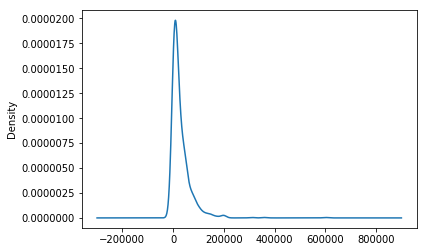

In [40]:
%matplotlib inline
df_prj.loanAmount.plot(kind='kde');
df_prj.loanApplyCity.value_counts().head(20)

In [38]:
df_prj['year'] = df_prj.loanStDt.apply(lambda x: pd.to_datetime(x).year)

df_prj[df_prj.year==2017].loanStDt.apply(lambda x: pd.to_datetime(x))

405   2017-01-06 06:32:20
406   2017-01-04 21:02:19
407   2017-01-05 20:02:20
411   2017-01-01 11:02:19
414   2017-01-01 22:02:35
415   2017-01-05 17:17:20
416   2017-01-03 12:32:19
417   2017-01-05 08:47:40
418   2017-01-04 21:32:26
419   2017-01-06 11:51:25
420   2017-01-07 10:32:19
421   2017-01-10 21:47:20
422   2017-01-10 23:17:32
423   2017-01-11 18:32:40
424   2017-01-13 12:19:19
425   2017-01-13 16:47:32
426   2017-01-13 16:47:43
427   2017-01-18 20:17:51
428   2017-01-20 12:17:33
429   2017-01-21 22:32:19
430   2017-01-21 22:32:19
431   2017-01-22 11:47:36
432   2017-01-23 12:32:25
433   2017-01-23 12:32:34
434   2017-01-23 16:47:31
435   2017-01-24 16:32:20
436   2017-02-13 10:02:30
437   2017-02-22 16:05:28
438   2017-02-27 12:20:52
439   2017-02-27 15:06:06
              ...        
801   2017-10-24 21:54:59
802   2017-10-26 10:25:13
803   2017-10-26 16:09:59
804   2017-10-28 12:15:20
805   2017-10-28 21:09:59
806   2017-10-29 19:54:59
807   2017-11-02 00:14:59
808   2017-1

In [47]:
# 2018年的项目没有借款人详细信息
df_prj[df_prj.year==2018].projectID.head(5)

831    17579483
832    17580868
833    17580989
834    17581178
835    17581264
Name: projectID, dtype: int64

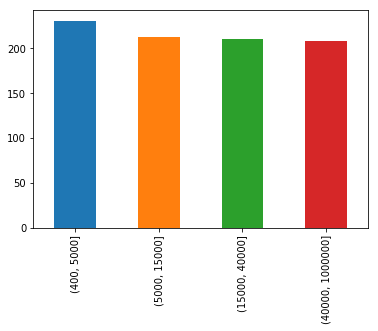

In [66]:
df_prj['ageGroup'] = pd.cut(df_prj.borrowerAge,[18,24,35,45,70])
df_prj['loanAmtGroup'] =  pd.cut(df_prj.loanAmount,[400, 5000, 15000, 40000, 1000000])
df_prj['loanMonth'] = pd.Categorical(df_prj.loanMonth)
df_prj['loanAmtGroup'].value_counts().plot(kind='bar')

In [69]:
df_X = df_prj.loc[df_prj.year!=2018,['borrowerGender', 'ageGroup', 'workCity','education',
       'marriageStatus', 'incomeRange', 'employerType','loanAmtGroup',
        'loanMonth']]
df_y = df_prj.loc[df_prj.year!=2018 ,'overdueCount']>0

In [77]:
df_X_dummies = pd.get_dummies(df_X, df_X.columns)

In [79]:
from mlxtend.frequent_patterns import apriori
apriori(df_X_dummies[df_y==True],0.05, use_colnames= True).head(20)

,support,itemsets
0,0.337900,[borrowerGender_女]
1,0.662100,[borrowerGender_男]
2,0.109589,"[ageGroup_(18, 24]]"
3,0.591324,"[ageGroup_(24, 35]]"
4,0.196347,"[ageGroup_(35, 45]]"
5,0.102740,"[ageGroup_(45, 70]]"
6,0.146119,[workCity_上海]
7,0.235160,[workCity_北京]
8,0.109589,[workCity_广东]
9,0.054795,[workCity_江苏]


In [105]:
X_train, X_test, y_train, y_test = train_test_split(df_X_dummies, df_y, test_size=0.3)

In [111]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# 决策树

md_clf = DecisionTreeClassifier(max_depth= 3, min_samples_split=3,min_samples_leaf=1)
md_clf.fit(X_train, y_train)
md_clf.score(X_train, y_train)

0.59896729776247848

In [112]:
from sklearn.ensemble import RandomForestClassifier
md_clf = RandomForestClassifier(max_depth= 3, min_samples_split=3,min_samples_leaf=1)
md_clf.fit(X_train, y_train)
md_clf.score(X_train, y_train)

0.63339070567986233

In [134]:
from sklearn.ensemble import  AdaBoostClassifier
md_clf = AdaBoostClassifier(learning_rate=1)
md_clf.fit(X_train, y_train)
fit_score  = md_clf.score(X_train, y_train)
test_score = accuracy_score(y_test, md_clf.predict(X_test))
print('fit score: %f, test score: %f'%(fit_score,test_score))

fit score: 0.679862, test score: 0.544000


In [145]:
#import lightgbm 
import lightgbm as lgb 
train_data=lgb.Dataset(X_train,label=y_train)

#setting parameters for lightgbm
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']


In [151]:
#training our model using light gbm
num_round=50

%time lgbm=lgb.train(param,train_data,num_round)


Wall time: 182 ms


In [153]:
#predicting on test set
ypred2=lgbm.predict(X_test)
ypred2[0:5]  # showing first 5 predictions

array([ 0.51070423,  0.5600471 ,  0.28177884,  0.52698135,  0.55677811])

In [155]:
#converting probabilities into 0 or 1
for i in range(0,len(y_test)):
    if ypred2[i]>=.5:       # setting threshold to .5
       ypred2[i]=1
    else:  
       ypred2[i]=0

In [156]:
#calculating accuracy
accuracy_lgbm = accuracy_score(ypred2,y_test)
print('lgbm: %f' % accuracy_lgbm)
y_test.value_counts()

lgbm: 0.520000


False    126
True     124
Name: overdueCount, dtype: int64

In [160]:
from sklearn.metrics import roc_auc_score
#calculating roc_auc_score for light gbm. 
auc_lgbm = roc_auc_score(y_test,ypred2)
auc_lgbm

0.520673323092678

In [163]:
y_test.value_counts()

False    126
True     124
Name: overdueCount, dtype: int64